In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, normalize
import prepare as p
import numpy as np
import pandas as pd
np.set_printoptions(threshold=np.inf)

In [33]:
# import data
df = p.loadData("alldata.csv", clean=False, alldata=True)

# remove call records with purpose 'energy'/'family'
df = df[(df.purpose == 'health') & ~(df.purpose == 'energy') & ~(df.purpose == 'family')]

In [34]:
def prep(df):
    '''
    Input Pandas data frame.
    Binarise labels, extract columns, one hot encode categorical variables.
    Return targets and data consisting of features as Numpy array.
    '''
    # target variable
    target = df.contact.to_numpy()
    # encode target as 0 and 1
    target = np.where(target==True, 1, 0)

    # predictor variables
    # extract columns with categorical data
    categorical = df[['dayofweek','hour','month', 'purpose']]
    # extract columns with continuous data
    # also normalize if needed
    continuous = normalize(df[['latitude','longitude']].to_numpy())
    
    # one hot encode categorical data
    encode = OneHotEncoder()
    oneHotCats = encode.fit_transform(categorical).toarray()

    # concatenate one hot encoded data with continous data
    data = np.concatenate((oneHotCats, continuous), axis=1)
    
    return (target, data)

In [4]:
import random
df.contact.value_counts()/len(df)
contact = df[df.contact == 1].sample(1000000)
nocontact = df[df.contact == 0].sample(1000000)
sample = pd.concat([contact, nocontact]).sample(2000000)
sample.contact.value_counts()/len(sample)
df = sample

False    0.710509
True     0.289491
Name: contact, dtype: float64

ValueError: Cannot take a larger sample than population when 'replace=False'

In [35]:
# target variable
target = df.contact.to_numpy()
# encode target as 0 and 1
target = np.where(target==True, 1, 0)

# predictor variables
# extract columns with categorical data
categorical = df[['dayofweek','hour','month','purpose']]
# extract columns with continuous data
continuous = df[['latitude','longitude']].to_numpy()

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
continuous = scaler.fit_transform(continuous)

In [37]:
# one hot encode categorical data
encode = OneHotEncoder()
oneHotCats = encode.fit_transform(categorical).toarray()

# concatenate one hot encoded data with continous data
data = np.concatenate((oneHotCats, continuous), axis=1)

In [38]:
from sklearn import metrics

def my_custom_loss_func(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    return(metrics.auc(fpr, tpr))

my_scorer = metrics.make_scorer(my_custom_loss_func, greater_is_better=True)

In [30]:
# specify algorithm
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

class_weight = df.contact.value_counts()/len(df)
class_weight = {0: 1/class_weight[0], 1: 1/class_weight[1]}

algorithm = LinearSVC(class_weight=class_weight, max_iter=5000)

# define paramater space
space = dict()
space['C']: [0.1, 1, 10, 100]
space['gamma']: [1, 0.1, 0.01, 0.001]

# choose number of folds
n_folds = 3

# how many times do you want to sample the paramater space?
n_samples = 20

# perform hyperparameter tuning with randomised grid search, plus
# stratified cross validation
clf = CalibratedClassifierCV(base_estimator=algorithm)

# search for best hyperparameterisation
calibrated_model = clf.fit(data, target)

# print('Best Calibration: %s' % best_model.best_score_)
# print('Best Hyperparameters: %s' % best_model.best_params_)

# the first column in preds is P(no contact | date, time, etc.)
# the second column in preds is P(contact | data, time, etc.)
preds = calibrated_model.predict_proba(data)
# show first 5 rows of preds
preds[:5]

array([[0.7003432 , 0.2996568 ],
       [0.70814118, 0.29185882],
       [0.66877286, 0.33122714],
       [0.67856605, 0.32143395],
       [0.73328988, 0.26671012]])

In [42]:
target[:5]

array([0, 0, 0, 0, 0])

In [42]:
# specify algorithm
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

class_weight = df.contact.value_counts()/len(df)
class_weight = {0: 1/class_weight[0], 1: 1/class_weight[1]}

algorithm = LinearSVC(class_weight=class_weight, max_iter=5000)

# define paramater space
space = dict()
space['C']: [0.1, 1, 10, 100]
space['gamma']: [1, 0.1, 0.01, 0.001]

# choose number of folds
n_folds = 3

# how many times do you want to sample the paramater space?
n_samples = 20

# perform hyperparameter tuning with randomised grid search, plus
# stratified cross validation
clf = GridSearchCV(estimator=algorithm,
                  param_grid=space,
                  scoring=my_scorer,
                  n_jobs=4,
                  pre_dispatch='n_jobs*0.95',
                  cv=n_folds)

# search for best hyperparameterisation
best_model = clf.fit(data, target)

print('Best PR AUC score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)

calibration_clf = CalibratedClassifierCV(clf.best_estimator_)
calibrated_model = calibration_clf.fit(data, target)

# the first column in preds is P(no contact | date, time, etc.)
# the second column in preds is P(contact | data, time, etc.)
preds = calibrated_model.predict_proba(data)
# show first 5 rows of preds
preds[:5]

Best PR AUC score: 0.5291955871829553
Best Hyperparameters: {}


array([[0.7003432 , 0.2996568 ],
       [0.70814118, 0.29185882],
       [0.66877286, 0.33122714],
       [0.67856605, 0.32143395],
       [0.73328988, 0.26671012]])

In [43]:
import pickle
filename = 'svc_health_only_model.p'
with open(filename, 'wb') as filehandler:
    pickle.dump(calibrated_model, filehandler)

In [44]:
import pickle
filename = 'svc_health_only_model.p'
model = pickle.load(open(filename, 'rb'))

In [45]:
# sample some of the data not used for training
#test_y, test_x = prep(remaining.sample(1000000))

# import data
df = p.loadData("alldata.csv", clean=False, alldata=True)

# remove call records with purpose 'energy'/'family'
df = df[(df.purpose == 'health') & ~(df.purpose == 'energy') & ~(df.purpose == 'family')]
test_y, test_x = prep(df)

In [46]:
test_x.shape

(1781898, 32)

In [47]:
pred_y = model.predict_proba(test_x)[:,1]

In [48]:
from sklearn.metrics import confusion_matrix
precision = []
recall = []
ps = []
baseline = test_y.sum()/len(test_y)
for p in np.arange(0,1,0.05):
    classify = np.where(pred_y >= p, 1, 0).flatten()
    tn, fp, fn, tp = confusion_matrix(test_y, classify).ravel()
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))
    ps.append(p)

<ipython-input-48-b2adc507a439>:9: RuntimeWarning: invalid value encountered in long_scalars
  precision.append(tp/(tp+fp))


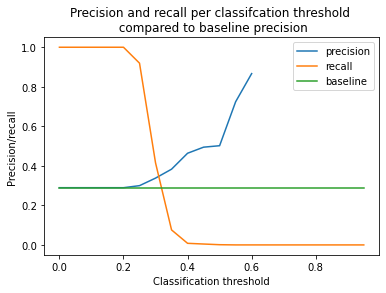

In [49]:
import matplotlib.pyplot as plt
plt.plot(ps, precision, label='precision');
plt.plot(ps, recall, label='recall');
plt.plot(ps, [baseline]*len(ps), label='baseline');
plt.xlabel("Classification threshold")
plt.ylabel("Precision/recall")
plt.title("Precision and recall per classifcation threshold \n compared to baseline precision")
plt.legend();

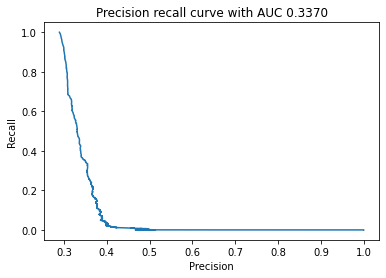

In [50]:
from sklearn import metrics
prec, rec, thresholds = metrics.precision_recall_curve(test_y, pred_y.ravel(), pos_label=1)
plt.plot(prec, rec)
pr_auc = metrics.auc(rec, prec)
plt.xlabel("Precision");
plt.ylabel("Recall");
plt.title("Precision recall curve with AUC " + str(pr_auc)[:6]);

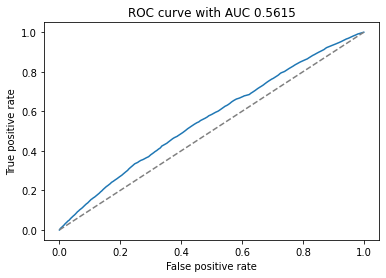

In [51]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y.ravel())
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr);
plt.plot([0,1],[0,1], '--', color='grey')
plt.xlabel("False positive rate");
plt.ylabel("True positive rate");
plt.title("ROC curve with AUC " + str(auc)[:6]);

In [52]:
import pickle
filename = 'svc_health_only.p'
with open(filename, 'wb') as filehandler:
    pickle.dump(preds, filehandler)

In [53]:
filename = 'svc_health_only_target.p'
with open(filename, 'wb') as filehandler:
    pickle.dump(target, filehandler)